In [8]:
import os
import numpy as np
import pandas as pd
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from TSB_UAD.models.damp import DAMP
from TSB_UAD.vus.metrics import get_metrics
from TSB_UAD.models.matrix_profile import MatrixProfile
from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.imondrian.mondrianforest import MondrianForest
from TSB_UAD.models.sand import SAND
# from TSB_UAD.models.lstm import lstm
from sklearn.preprocessing import MinMaxScaler
import math 
from TSB_UAD.vus import basic_metrics

# you might also need to set 
# plt.rcParams['text.usetex'] = False
# in plotFig for it to run!
# it had issues otherwise

# Only run this if you do not have the normality 1,2 and 3 datasets
# in your current working directory, so that they can be created!
# To create them, run this inside TSB_UAD root directory, as created from 
# https://github.com/TheDatumOrg/TSB-UAD after following the instructions
# and downloading the appropriate (public) dataset
i_have_the_datasets_in_my_dir = True
if not i_have_the_datasets_in_my_dir:
    ts1 = "data/TSB-UAD-Public/Occupancy/room-occupancy.train.csv@5.out"
    ts2 = "data/TSB-UAD-Public/YAHOO/YahooA3Benchmark-TS1_data.out"
    ts3 = "data/TSB-UAD-Public/NASA-MSL/T-5.train.out"

    out_names = ['room-occupancy.train.csv@5.out', 'yahoo+occupancy.csv', 'yahoo+occupancy+nasa.csv']

    timeseries = [ts1, ts2, ts3]
    dfs = []
    i = 0
    for ts in timeseries:
        if not os.path.exists(out_names[i]):
            dfs.append(pd.read_csv(ts, header=None).dropna().to_numpy())
            combined = np.vstack(tuple(dfs))
            pd.DataFrame(combined).to_csv(out_names[i], header=False, index=False)

In [9]:
# Define dataset names and util functions
normality1 = 'room-occupancy.train.csv@5.out'
normality2 = 'yahoo+occupancy.csv'
normality3 = 'yahoo+occupancy+nasa.csv'
def load_dataset(filepath):
    """ Loads a dataset in csv format.

    :param filepath: the name of the dataset
    :return: the data and the labels from this dataset"""
    df = pd.read_csv(filepath, header=None).dropna().to_numpy()
    data = df[:, 0].astype(float)
    labels = df[:, 1].astype(int)
    return data, labels

def preprocess(data):
    """Proprocesses the data, finds an appropriate sliding window length
    and creates a 2D array of the dataset itself with sliding windows.
    
    :param data: the dataset itself, as a dataframe column
    :return: the modified data into a 2D array and the sliding window size"""
    slidingWindow = find_length(data)
    X_data = Window(window=slidingWindow).convert(data).to_numpy()
    return X_data, slidingWindow

def evaluate(score, original_data, labels, modelName, slidingWindow, name=None, apply_sliding_window=True): 
    """This method prints the associated metrics from 
    TSB UAD and also plots the scores appropriately
    :param score: the scores for all data points of the sliding windows
    :param original data: the original dataset
    :param: labels: the original true labels of the data
    :param modelName: your model's name
    :param slidingWindow: the sliding window used for these data
    :param name: your file name
    
    :return: This method does not return anything, it only prints and plots the results"""
    # post processing
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    if apply_sliding_window:
        score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
    results = get_metrics(score, labels, metric="all", slidingWindow=slidingWindow)
    for metric in results.keys():
        print(metric, ":", results[metric])
    plotFig(original_data[:len(score)], labels[:len(score)], score, slidingWindow, fileName=name, modelName=modelName)

In [2]:
def run_iforest(X_data, labels, n_estimators=100, max_samples=256, online=False, variant=1, batch_size=500, verbose=True):
    """ A wrapper for running the isolation forest algorithm.  
    :param X_data: the 2D array of the data, after preprocessing
    :param labels: the true labels, if available (will be ignored)
    :param n_estimators: the number of estimators/trees to fit
    :param max_samples: the subsampling size
    :param online: boolean, true if it is to be used in a streaming setting
    :param variant: integer, either 1 or 2, 1 being a naive version of IForest, 2 uses Mondrian Forests 
    improvement
    :param batch_size: the batch size for streaming
    :param verbose: print useful  information as the model is fit
    
    :return: the scores for the data points, after fitting the trees"""
    clf = IForest(n_jobs=1, n_estimators=n_estimators, max_samples=max_samples)
    x = X_data
    clf.fit(X=x, y=labels, online=online, verbose=verbose, batch_size=batch_size, variant=variant)
    score = clf.decision_scores_
    return score

def run_sand(data, slidingWindow, init_length=500, batch_size=500, alpha=.5, verbose=False,):
    """ A wrapper for running the SAND algorithm.
    
    :param data: the original array of the data, no preprocessing
    :param slidingWindow: the length of the sliding window for this data
    :param init_length: an integer for how much data is to be used for model initialization
    :param batch_size: an integer of how much data will be used to simulate the online setting
    :param alpha: a real value inside [0,1], typically set to 0.5 as suggested in the paper
    :param verbose: print useful information as the model is fit

    :return: the scores for the data points, after fitting the model
    """
    clf = SAND(pattern_length=slidingWindow, subsequence_length=4*slidingWindow)
    clf.fit(data, overlaping_rate=int(4*slidingWindow), online=True, alpha=alpha, init_length=init_length, batch_size=batch_size,verbose=verbose,) # takes 1 minute
    score = clf.decision_scores_
    return score

# Normality 1 - assessments

AUC_ROC : 0.818657513034944
AUC_PR : 0.5447524896293161
Precision : 0.7933579335793358
Recall : 0.12434933487565067
F : 0.21500000000000002
Precision_at_k : 0.12434933487565067
Rprecision : 0.7933579335793358
Rrecall : 0.03985890652557319
RF : 0.07590432212550846
R_AUC_ROC : 0.8719734566265185
R_AUC_PR : 0.6483886909985223
VUS_ROC : 0.845582048707562
VUS_PR : 0.5879549401754411
Affiliation_Precision : 0.8158601375826701
Affiliation_Recall : 0.2730560764078171


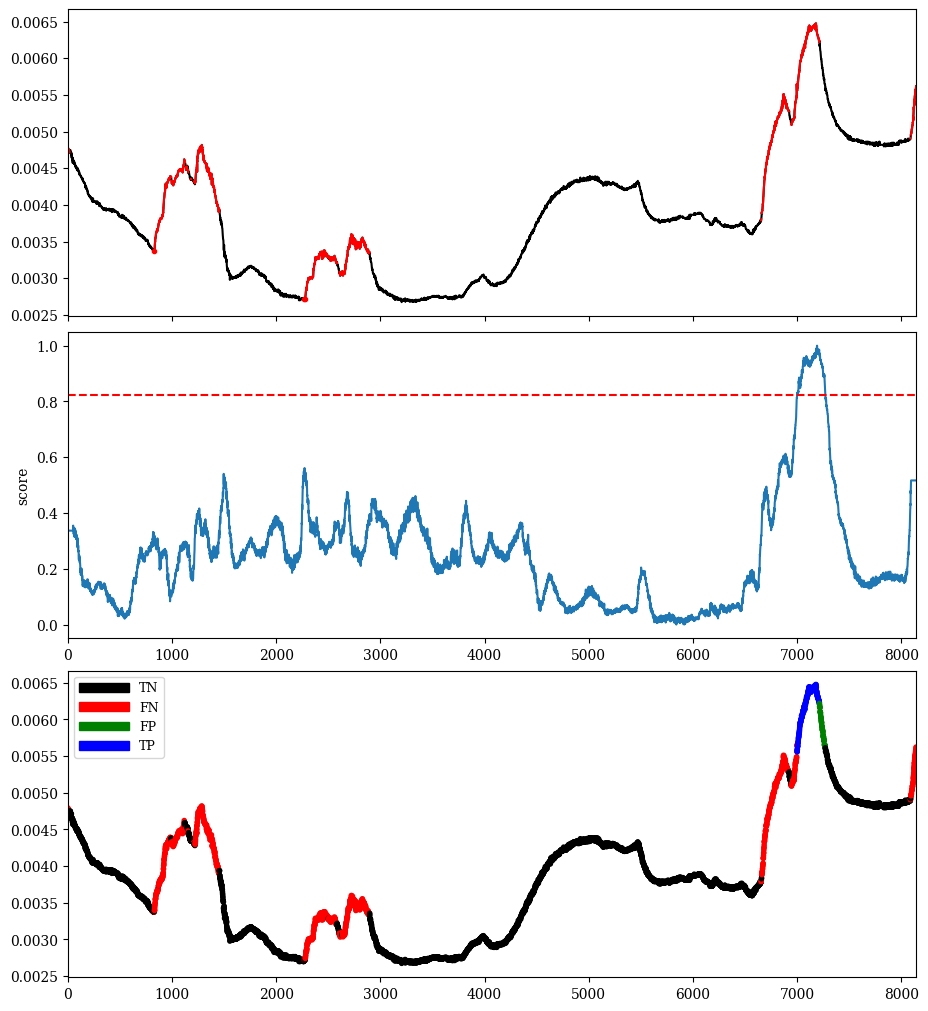

In [ ]:
# Run IForest (offline)
modelName = 'IForest'
data, labels = load_dataset(normality1)
X_data, w  =  preprocess(data)
score = run_iforest(X_data, labels, )
evaluate(score, data, labels, modelName, w,)

0-->500-->1000-->1500-->2000-->2500-->3000-->3500-->4000-->4500-->5000-->5500-->6000-->6500-->7000-->7500-->8000-->

/home/lazaros/.conda/envs/TSB/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (44). max_samples will be set to n_samples for estimation.
  warn(


AUC_ROC : 0.818657513034944
AUC_PR : 0.5447524896293161
Precision : 0.7933579335793358
Recall : 0.12434933487565067
F : 0.21500000000000002
Precision_at_k : 0.12434933487565067
Rprecision : 0.7933579335793358
Rrecall : 0.03985890652557319
RF : 0.07590432212550846
R_AUC_ROC : 0.8719734566265185
R_AUC_PR : 0.6483886909985223
VUS_ROC : 0.845582048707562
VUS_PR : 0.5879549401754411
Affiliation_Precision : 0.8158601375826701
Affiliation_Recall : 0.2730560764078171


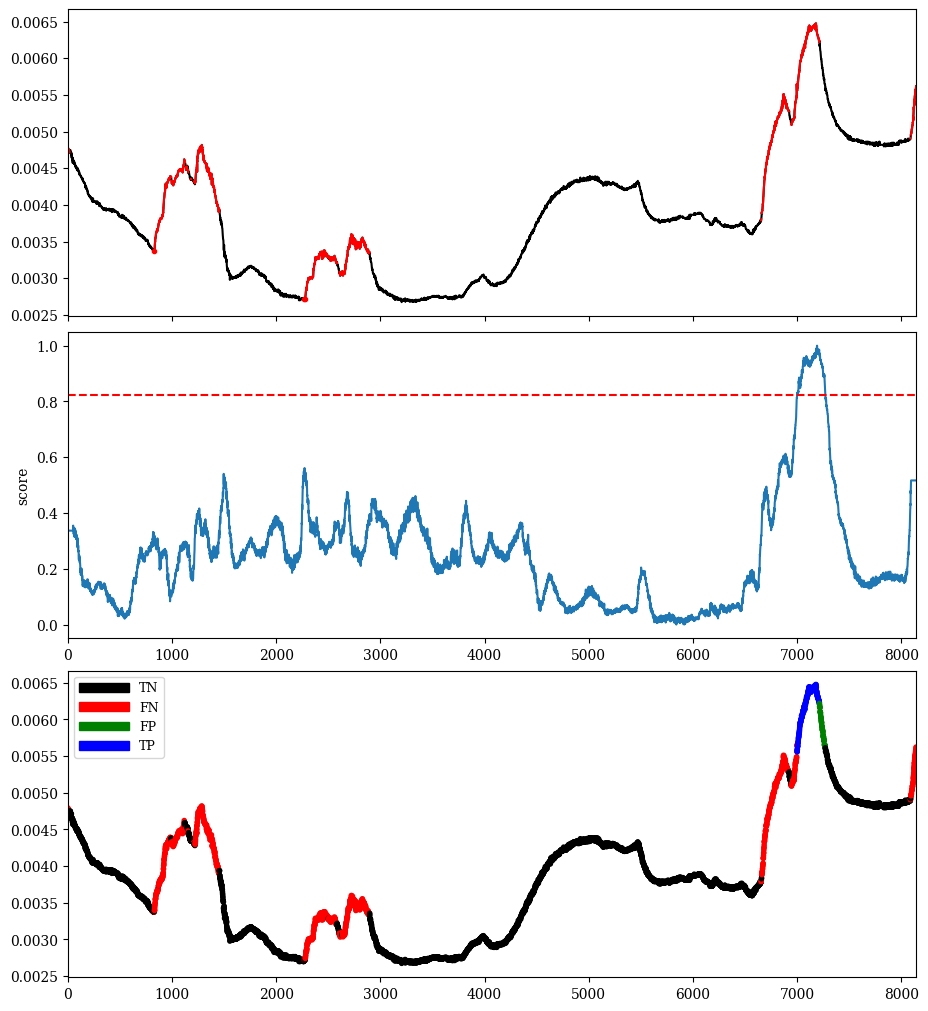

In [ ]:
# Run IForest (online naive)
modelName = 'IForest (online - naive)'
data, labels = load_dataset(normality1)
X_data, w =  preprocess(data)
run_iforest(X_data, labels, n_estimators=100, max_samples=256, online=True, variant=1, batch_size=500)
evaluate(score, data, labels, modelName, w, )

Training on 8044 samples of dimension 100
0-->500-->1000-->1500-->2000-->2500-->3000-->3500-->4000-->4500-->5000-->5500-->6000-->6500-->7000-->7500-->8000-->8044 [END]
AUC_ROC : 0.818657513034944
AUC_PR : 0.5447524896293161
Precision : 0.7933579335793358
Recall : 0.12434933487565067
F : 0.21500000000000002
Precision_at_k : 0.12434933487565067
Rprecision : 0.7933579335793358
Rrecall : 0.03985890652557319
RF : 0.07590432212550846
R_AUC_ROC : 0.8719734566265185
R_AUC_PR : 0.6483886909985223
VUS_ROC : 0.845582048707562
VUS_PR : 0.5879549401754411
Affiliation_Precision : 0.8158601375826701
Affiliation_Recall : 0.2730560764078171


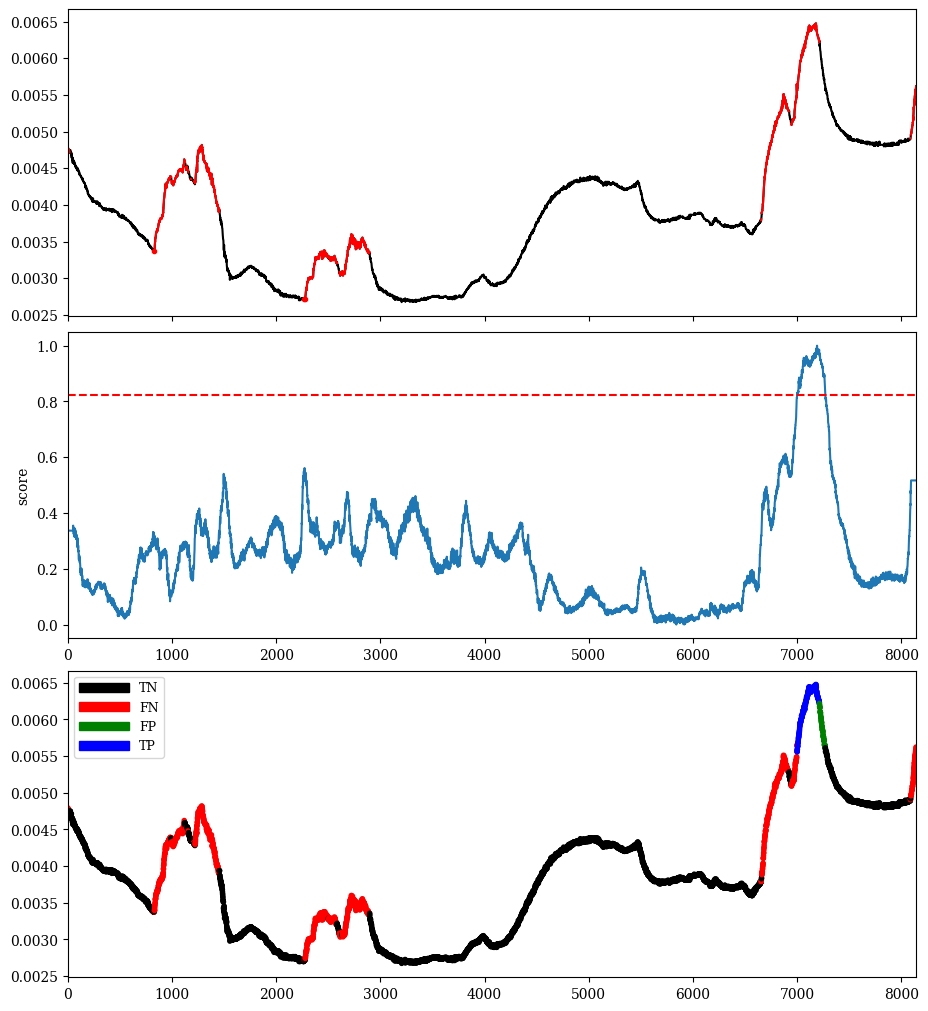

In [6]:
# Run IForest (online improved)
modelName = 'IForest (online - improved using MondrianForests)'
data, labels = load_dataset(normality1)
X_data, w =  preprocess(data)
run_iforest(X_data, labels, n_estimators=100, max_samples=256, online=True, variant=2, batch_size=500)
evaluate(score, data, labels, modelName, w)

AUC_ROC : 0.6577841397766562
AUC_PR : 0.32868166702792684
Precision : 0.0
Recall : 0.0
F : 0.0
Precision_at_k : 0.0
Rprecision : 0
Rrecall : 0.0
RF : 0
R_AUC_ROC : 0.6112223800373067
R_AUC_PR : 0.34501799180552717
VUS_ROC : 0.6223275203395598
VUS_PR : 0.3321729248227341
Affiliation_Precision : 0.7393879156339629
Affiliation_Recall : 0.5391793206640303


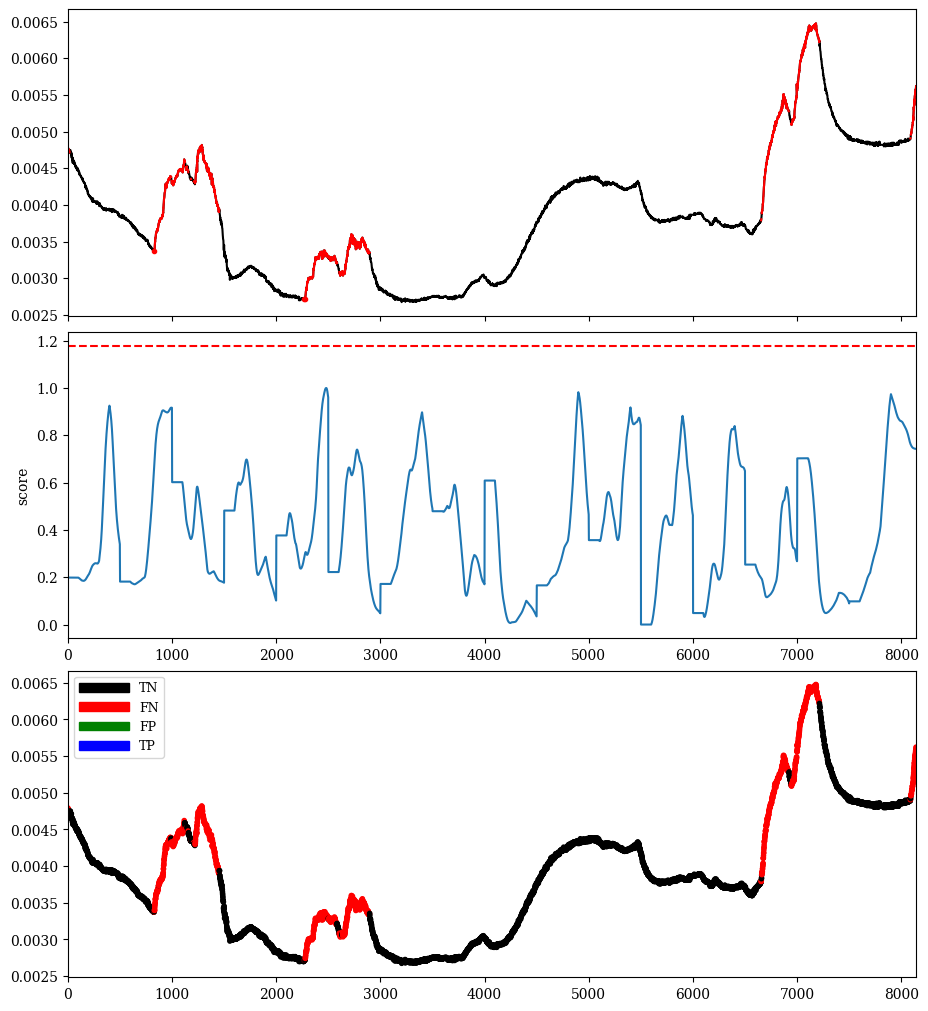

In [ ]:
# Run SAND (online - baseline)
modelName = 'SAND (online - baseline)'
data, labels = load_dataset(normality1)
score = run_sand(data, w, batch_size=500)
evaluate(score, data, labels, modelName, w, name=None,apply_sliding_window=False)

# Normality 2 - assessments

AUC_ROC : 0.5009209053768303
AUC_PR : 0.1651450024191154
Precision : 0.0
Recall : 0.0
F : 0.0
Precision_at_k : 0.0
Rprecision : 0.0
Rrecall : 0.0
RF : 0
R_AUC_ROC : 0.5855017921251343
R_AUC_PR : 0.23655872554755422
VUS_ROC : 0.511126920395737
VUS_PR : 0.2065497687831158
Affiliation_Precision : 0.4717859938176476
Affiliation_Recall : 0.3572761194029851


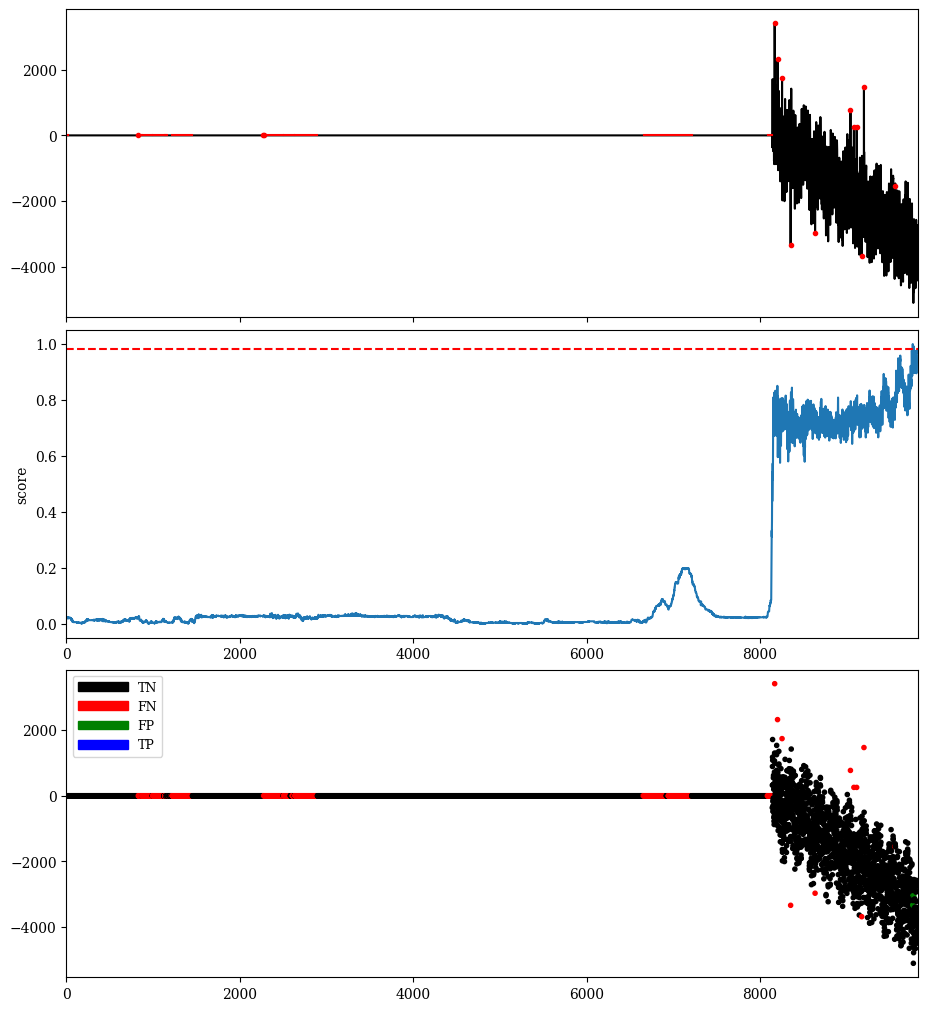

In [ ]:
# Run IForest (offline)
modelName = 'IForest'
data, labels = load_dataset(normality2)
X_data, w  =  preprocess(data)
score = run_iforest(X_data, labels, )
evaluate(score, data, labels, modelName, w, name=None)

0-->1000-->2000-->3000-->4000-->5000-->6000-->7000-->8000-->9000-->AUC_ROC : 0.5009209053768303
AUC_PR : 0.1651450024191154
Precision : 0.0
Recall : 0.0
F : 0.0
Precision_at_k : 0.0
Rprecision : 0.0
Rrecall : 0.0
RF : 0
R_AUC_ROC : 0.5855017921251343
R_AUC_PR : 0.23655872554755422
VUS_ROC : 0.511126920395737
VUS_PR : 0.2065497687831158
Affiliation_Precision : 0.4717859938176476
Affiliation_Recall : 0.3572761194029851


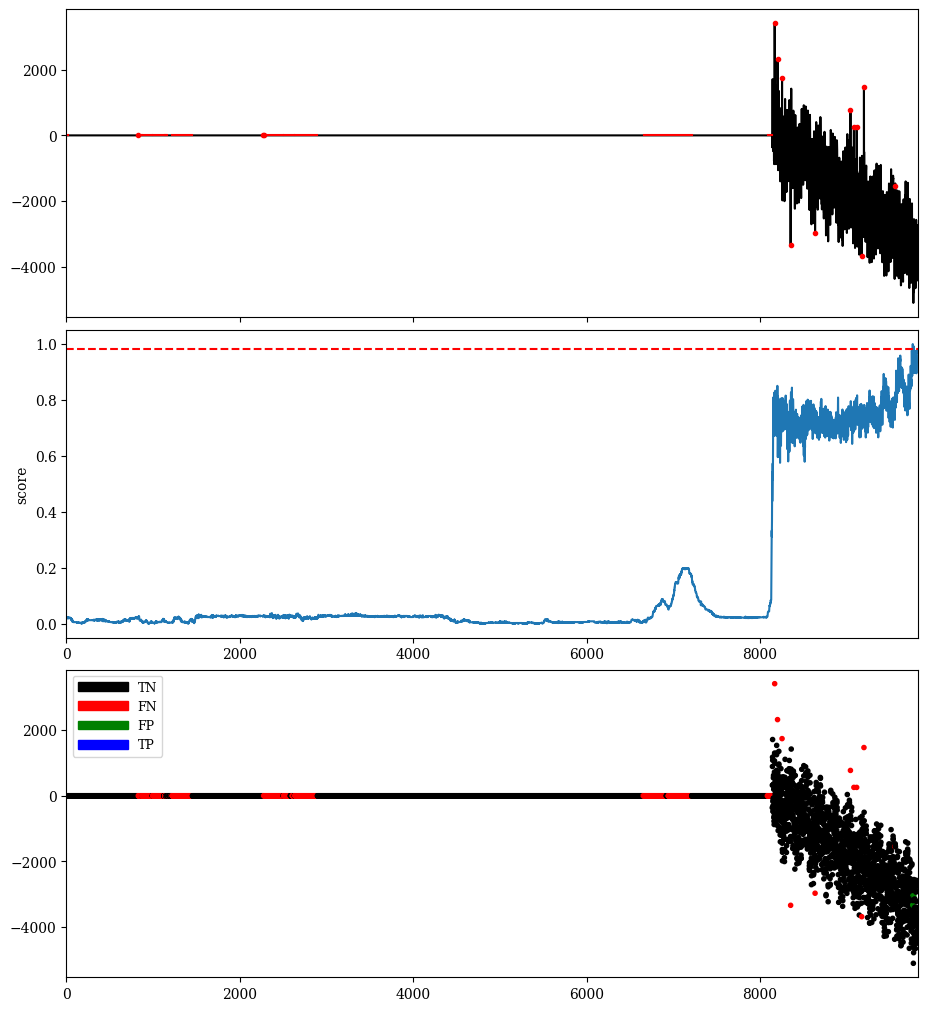

In [16]:
# Run IForest (online naive)
modelName = 'IForest (online - naive)'
data, labels = load_dataset(normality2)
X_data, w =  preprocess(data)
run_iforest(X_data, labels, n_estimators=100, max_samples=256, online=True, variant=1, batch_size=1000)
evaluate(score, data, labels, modelName, w, )

Training on 9800 samples of dimension 24
0-->1000-->2000-->3000-->4000-->5000-->6000-->7000-->8000-->9000-->9800 [END]
AUC_ROC : 0.5009209053768303
AUC_PR : 0.1651450024191154
Precision : 0.0
Recall : 0.0
F : 0.0
Precision_at_k : 0.0
Rprecision : 0.0
Rrecall : 0.0
RF : 0
R_AUC_ROC : 0.5855017921251343
R_AUC_PR : 0.23655872554755422
VUS_ROC : 0.511126920395737
VUS_PR : 0.2065497687831158
Affiliation_Precision : 0.4717859938176476
Affiliation_Recall : 0.3572761194029851


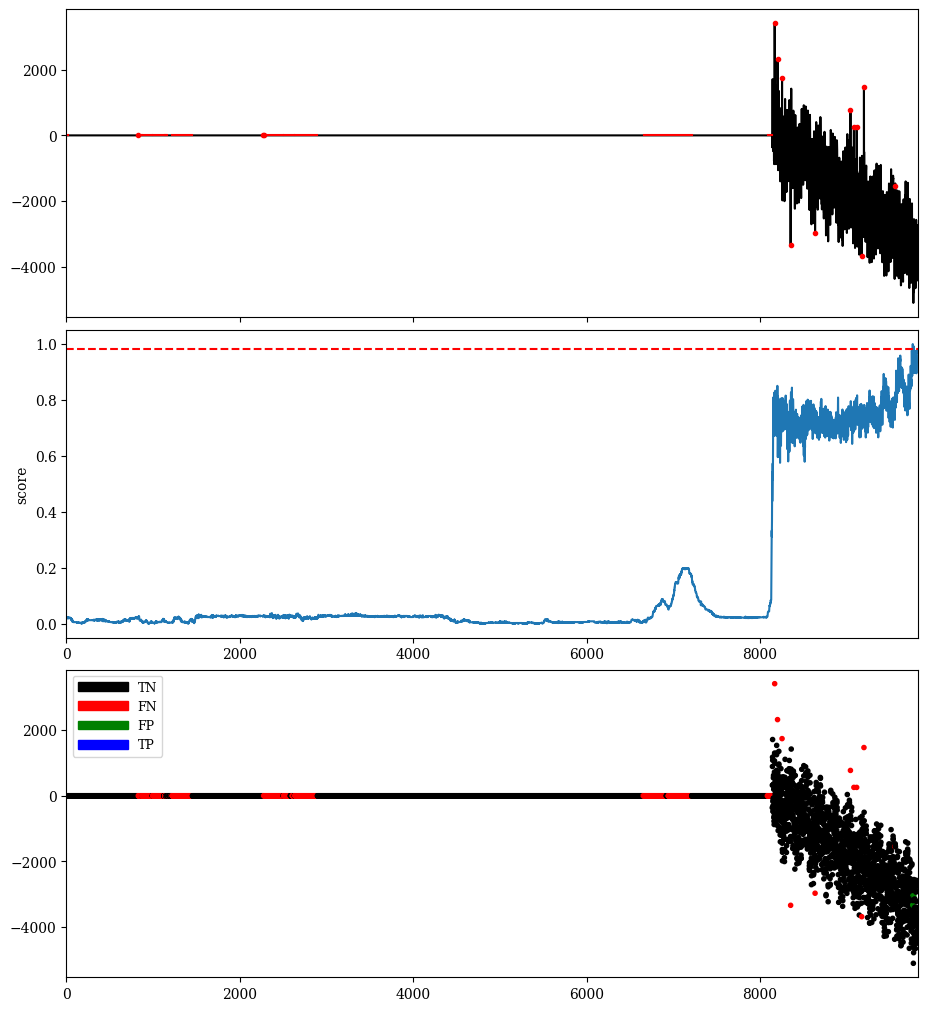

In [17]:
# Run IForest (online improved)
modelName = 'IForest (online - improved using MondrianForests)'
data, labels = load_dataset(normality2)
X_data, w =  preprocess(data)
run_iforest(X_data, labels, n_estimators=100, max_samples=256, online=True, variant=2, batch_size=1000)
evaluate(score, data, labels, modelName, w, )

AUC_ROC : 0.6416267432286579
AUC_PR : 0.2988379673939859
Precision : 0.0
Recall : 0.0
F : 0.0
Precision_at_k : 0.0
Rprecision : 0
Rrecall : 0.0
RF : 0
R_AUC_ROC : 0.5622193753070998
R_AUC_PR : 0.2920747027773265
VUS_ROC : 0.5626082867106675
VUS_PR : 0.2781017195868221
Affiliation_Precision : 0.7379884188274032
Affiliation_Recall : 0.8988675456690095


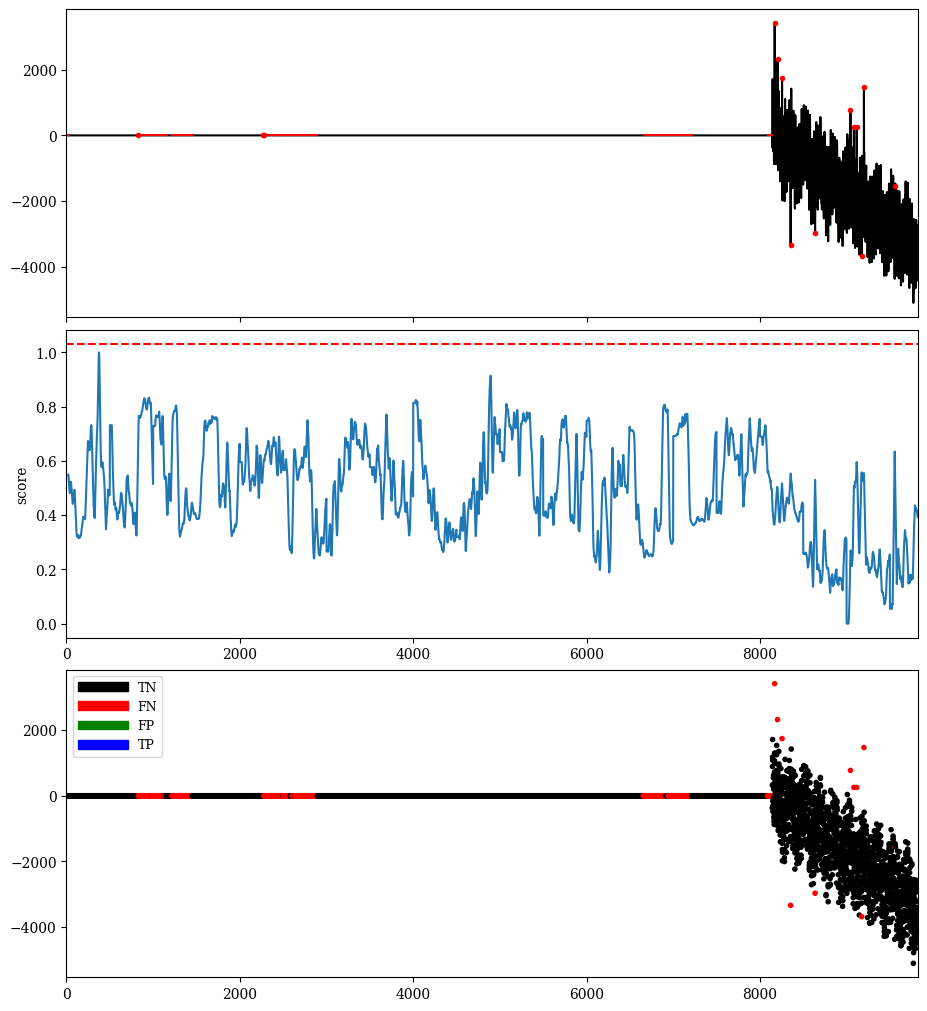

In [19]:
# Run SAND (online - baseline)
modelName = 'SAND (online - baseline)'
data, labels = load_dataset(normality2)
X_data, w =  preprocess(data)
score = run_sand(data, w)
evaluate(score, data, labels, modelName, w, name=None,apply_sliding_window=False)

# Normality 3 - assessments

AUC_ROC : 0.4064899515476448
AUC_PR : 0.11252212432499
Precision : 0.0
Recall : 0.0
F : 0.0
Precision_at_k : 0.0
Rprecision : 0.0
Rrecall : 0.0
RF : 0
R_AUC_ROC : 0.47655084944026027
R_AUC_PR : 0.15832234962937075
VUS_ROC : 0.41654305437610645
VUS_PR : 0.14010305950967694
Affiliation_Precision : 0.49880104957708915
Affiliation_Recall : 0.3531142365097589


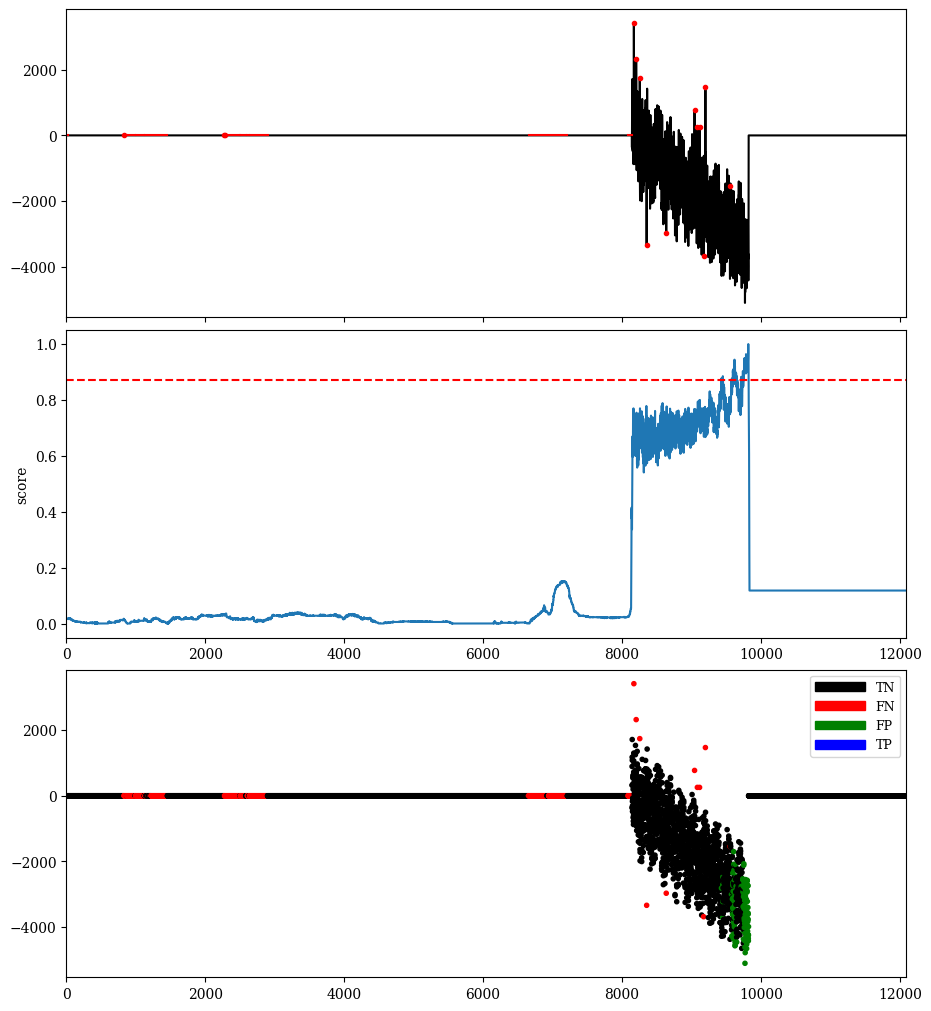

In [20]:
# Run IForest (offline)
modelName = 'IForest'
data, labels = load_dataset(normality3)
X_data, w  =  preprocess(data)
score = run_iforest(X_data, labels, )
evaluate(score, data, labels, modelName, w, )

0-->2000-->4000-->6000-->8000-->10000-->12000-->

/home/lazaros/.conda/envs/TSB/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (72). max_samples will be set to n_samples for estimation.
  warn(


AUC_ROC : 0.4064899515476448
AUC_PR : 0.11252212432499
Precision : 0.0
Recall : 0.0
F : 0.0
Precision_at_k : 0.0
Rprecision : 0.0
Rrecall : 0.0
RF : 0
R_AUC_ROC : 0.47655084944026027
R_AUC_PR : 0.15832234962937075
VUS_ROC : 0.41654305437610645
VUS_PR : 0.14010305950967694
Affiliation_Precision : 0.49880104957708915
Affiliation_Recall : 0.3531142365097589


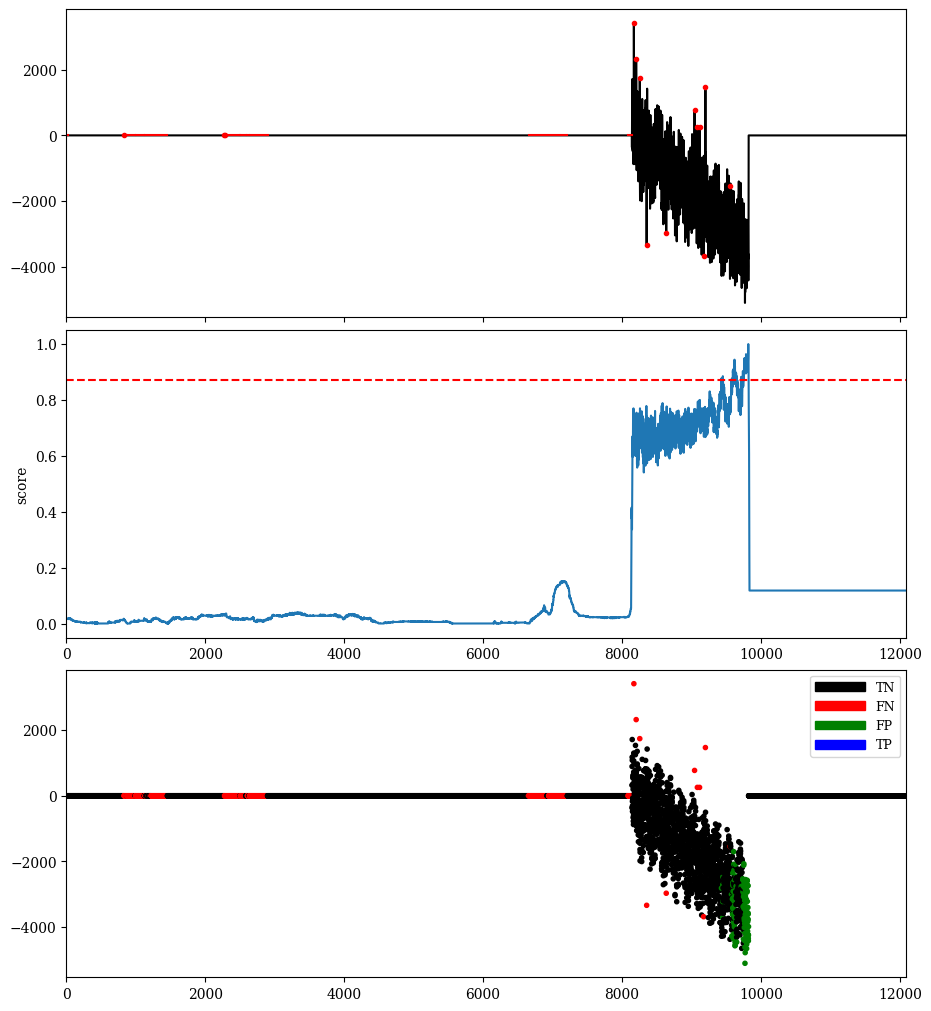

In [21]:
# Run IForest (online naive)
modelName = 'IForest (online - naive)'
data, labels = load_dataset(normality3)
X_data, w =  preprocess(data)
run_iforest(X_data, labels, n_estimators=100, max_samples=256, online=True, variant=1, batch_size=2000)
evaluate(score, data, labels, modelName, w, )

Training on 12072 samples of dimension 24
0-->2000-->4000-->6000-->8000-->10000-->12000-->12072 [END]
AUC_ROC : 0.4064899515476448
AUC_PR : 0.11252212432499
Precision : 0.0
Recall : 0.0
F : 0.0
Precision_at_k : 0.0
Rprecision : 0.0
Rrecall : 0.0
RF : 0
R_AUC_ROC : 0.47655084944026027
R_AUC_PR : 0.15832234962937075
VUS_ROC : 0.41654305437610645
VUS_PR : 0.14010305950967694
Affiliation_Precision : 0.49880104957708915
Affiliation_Recall : 0.3531142365097589


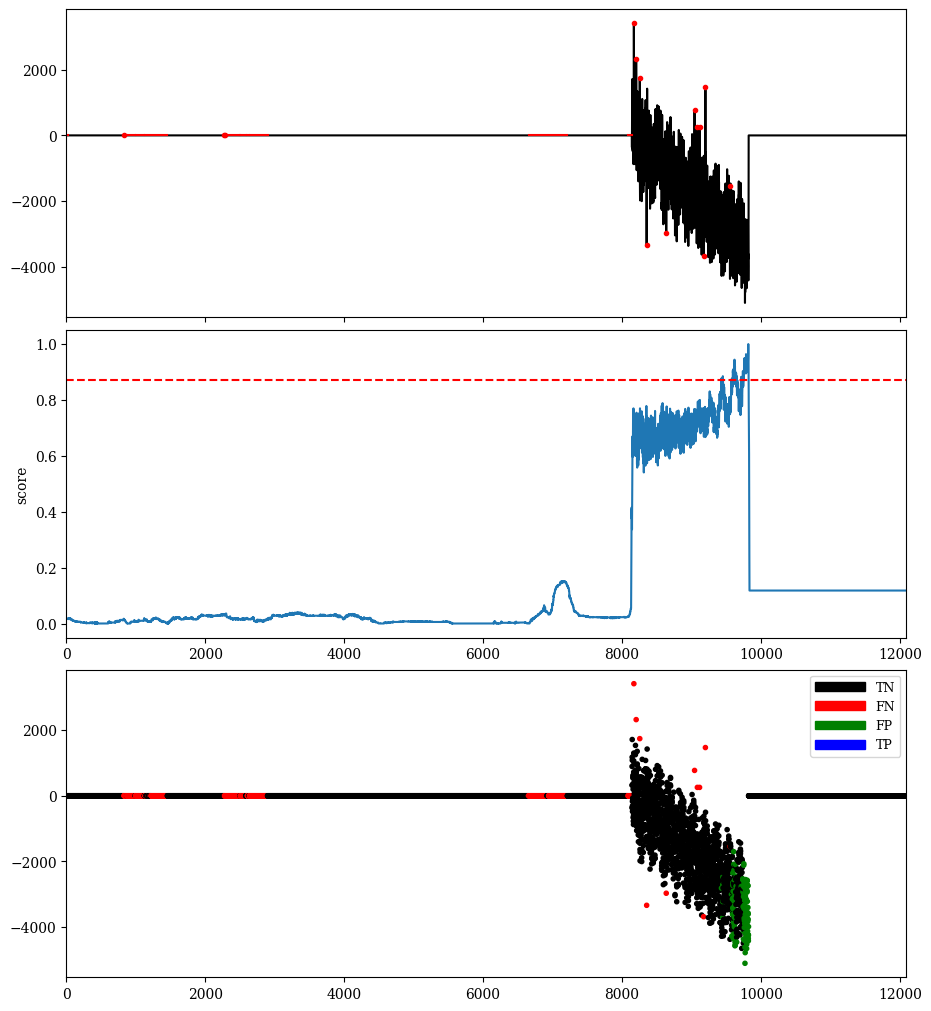

In [22]:
# Run IForest (online improved)
modelName = 'IForest (online - improved using MondrianForests)'
data, labels = load_dataset(normality3)
X_data, w =  preprocess(data)
run_iforest(X_data, labels, n_estimators=100, max_samples=256, online=True, variant=2, batch_size=2000)
evaluate(score, data, labels, modelName, w, )

0-->5000-->10000-->[STOP]: score length 12095
AUC_ROC : 0.5485778983999068
AUC_PR : 0.24443762503943384
Precision : 0.0
Recall : 0.0
F : 0.0
Precision_at_k : 0.0
Rprecision : 0
Rrecall : 0.0
RF : 0
R_AUC_ROC : 0.3423759642603788
R_AUC_PR : 0.18944816789992563
VUS_ROC : 0.3625247706252132
VUS_PR : 0.18387379351744543
Affiliation_Precision : 0.6739652363687545
Affiliation_Recall : 0.5342356833938032


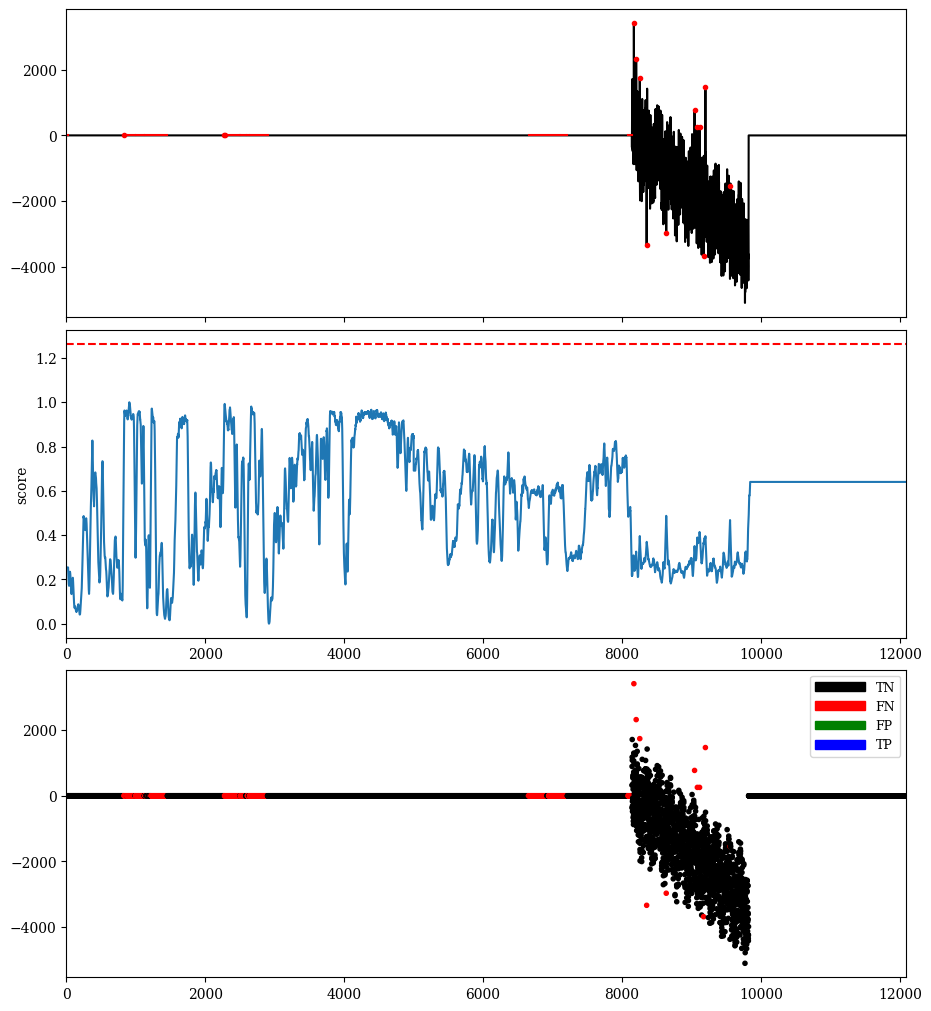

In [10]:
# Run SAND (online - baseline)
modelName = 'SAND (online - baseline)'
data, labels = load_dataset(normality3)
X_data, w =  preprocess(data)
score = run_sand(data, w, init_length=5000, batch_size=5000, verbose=True)
evaluate(score, data, labels, modelName, w, name=None,apply_sliding_window=False)